In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

PosixPath('/Users/ryusei/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


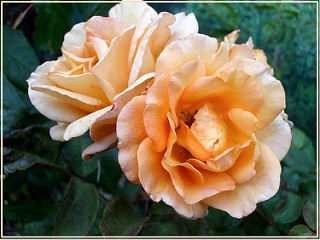

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

In [19]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


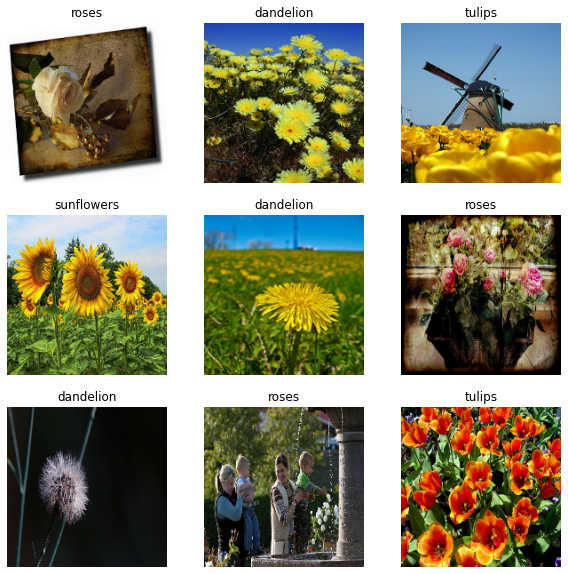

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [16]:
AUTOTUNE     = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [28]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 44s 473ms/step - loss: 1.3334 - accuracy: 0.4213 - val_loss: 1.1109 - val_accuracy: 0.5395
Epoch 2/3
92/92 [==============================] - 41s 449ms/step - loss: 1.0484 - accuracy: 0.5712 - val_loss: 0.9984 - val_accuracy: 0.5995
Epoch 3/3
92/92 [==============================] - 55s 599ms/step - loss: 0.9097 - accuracy: 0.6366 - val_loss: 0.9494 - val_accuracy: 0.6417


# tf.data.Datasetの活用

In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/ryusei/.keras/datasets/flower_photos/tulips/14235021006_dd001ea8ed_n.jpg'
b'/Users/ryusei/.keras/datasets/flower_photos/dandelion/510897767_918260db93.jpg'
b'/Users/ryusei/.keras/datasets/flower_photos/roses/12202373204_34fb07205b.jpg'
b'/Users/ryusei/.keras/datasets/flower_photos/daisy/5135131051_102d4878ca_n.jpg'
b'/Users/ryusei/.keras/datasets/flower_photos/daisy/9496209717_25a6ebdab6_m.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [9]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


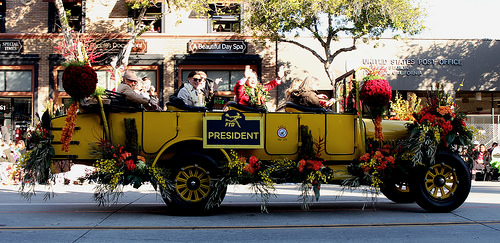

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [24]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [23]:
tf.strings.split(file_path, os.path.sep)

NameError: name 'file_path' is not defined

In [21]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [22]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

TypeError: in user code:


    TypeError: tf__process_path() takes 1 positional argument but 2 were given


In [52]:
for d in train_ds.take(1):
    print(d[0])

tf.Tensor(
[[[71.416664   64.668205   45.333336  ]
  [67.13426    66.75463    46.944447  ]
  [53.86111    60.22994    42.31327   ]
  ...
  [17.853394   34.611076   29.171307  ]
  [18.324081   30.70831    30.439823  ]
  [17.029314   25.85956    32.444443  ]]

 [[73.583336   68.703705   49.703705  ]
  [69.416664   68.75       49.77778   ]
  [58.435184   61.087963   44.425926  ]
  ...
  [16.504606   32.425877   29.495344  ]
  [13.986096   25.583282   27.652773  ]
  [10.629623   17.828691   27.657404  ]]

 [[73.84876    72.237656   53.9321    ]
  [70.34722    69.44907    51.449074  ]
  [64.61729    63.57253    48.117283  ]
  ...
  [16.5833     32.356377   29.60028   ]
  [12.449047   22.444393   27.745367  ]
  [ 9.439812   14.979927   26.202156  ]]

 ...

 [[37.543205   25.15432    33.848763  ]
  [34.842594   23.19908    32.587963  ]
  [40.06636    27.73303    36.466053  ]
  ...
  [11.34415    24.36113    30.310188  ]
  [10.078679   23.129602   28.976833  ]
  [ 3.8610992  16.8611     25.472

In [53]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

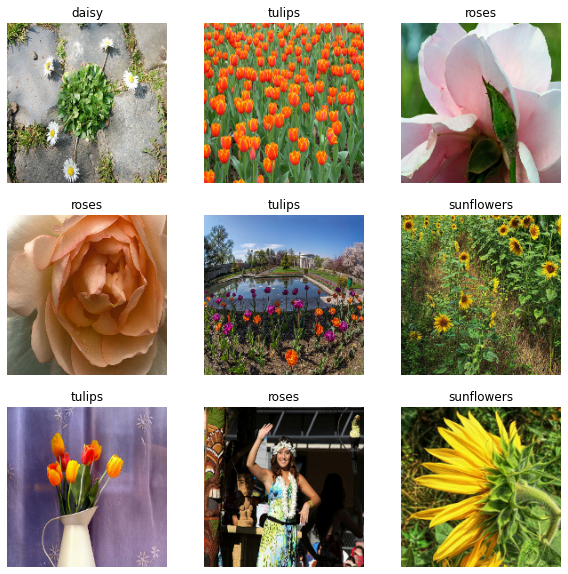

In [54]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [55]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 46s 497ms/step - loss: 0.7869 - accuracy: 0.6986 - val_loss: 0.8140 - val_accuracy: 0.6839
Epoch 2/3
92/92 [==============================] - 46s 504ms/step - loss: 0.6490 - accuracy: 0.7548 - val_loss: 0.7657 - val_accuracy: 0.7044
Epoch 3/3
92/92 [==============================] - 54s 589ms/step - loss: 0.4394 - accuracy: 0.8334 - val_loss: 0.7852 - val_accuracy: 0.7234


In [59]:
import keras

Using TensorFlow backend.


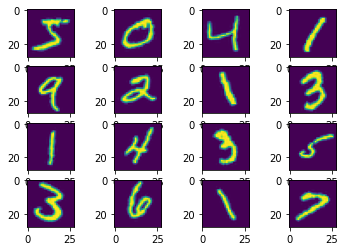

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

def rotate(image):
    return ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)

@tf.function
def rotate_tf(image):
    rotated = tf.py_function(rotate,[image],[tf.int32])
    return rotated[0]


(train_x, train_y), (test_x, test_y) =  keras.datasets.mnist.load_data()
train_x = train_x.reshape(-1,28,28,1)
train_ds = tf.data.Dataset.from_tensor_slices(train_x)
batched_train_ds = train_ds.map(rotate_tf).batch(16) #ここが肝心のMap


# pick images in first batch
first_batch = next(iter(batched_train_ds))
sample_images = first_batch.numpy().reshape((-1,28,28))

plt.figure(facecolor="white")
for i, sample_image in enumerate(sample_images):
  plt.subplot(4,4,i+1)
  plt.imshow(sample_image)
  plt.grid(False)
plt.show()

In [62]:
train_x.shape

(60000, 28, 28, 1)